In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glaucoma-detection/glaucoma.csv
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/537.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/521.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/539.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/501.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/544.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/489.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/576.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/503.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


# Prepare Glaucoma Dataset

In [3]:
class FullGlaucomaDataset(Dataset):
    def __init__(self, fundus_dir, origa_mat, origa_img_dir, acrima_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        # Fundus dataset
        for label_dir in ["Glaucoma_Negative", "Glaucoma_Positive"]:
            full_dir = os.path.join(fundus_dir, "Train", label_dir)
            label = 0 if "Negative" in label_dir else 1
            for f in glob.glob(full_dir + "/*.jpg"):
                self.samples.append((f,label))
        
        # ORIGA dataset
        import scipy.io
        origa_data = scipy.io.loadmat(origa_mat)['Origa']
        for i in range(len(origa_data[0])):
            fname = origa_data[0][i]['Filename'][0]
            label = int(origa_data[0][i]['Glaucoma'][0][0])
            img_path = os.path.join(origa_img_dir, fname)
            if os.path.exists(img_path):
                self.samples.append((img_path, label))
        
        # ACRIMA dataset
        for f in glob.glob(acrima_dir + "/*.jpg"):
            fname = os.path.basename(f)
            label = 1 if "_g_" in fname else 0
            self.samples.append((f,label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")  # 3 channels
        if self.transform:
            img = self.transform(img)
        return img, label


# Train/Validatin Split

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# 1️⃣ Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transforms for validation
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# 2️⃣ Paths
fundus_dir = "/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted"
origa_mat = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/OrigaList.mat"
origa_img_dir = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
acrima_dir = "/kaggle/input/glaucoma-detection/ACRIMA/Images"

# 3️⃣ Instantiate full dataset
full_dataset = FullGlaucomaDataset(
    fundus_dir=fundus_dir,
    origa_mat=origa_mat,
    origa_img_dir=origa_img_dir,
    acrima_dir=acrima_dir,
    transform=transform_train
)

# 4️⃣ Train/validation split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 5️⃣ DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Total samples:", len(full_dataset))
print("Train:", len(train_dataset), "Validation:", len(val_dataset))


Total samples: 1873
Train: 1498 Validation: 375


# Visualize Some Images

Training set samples:


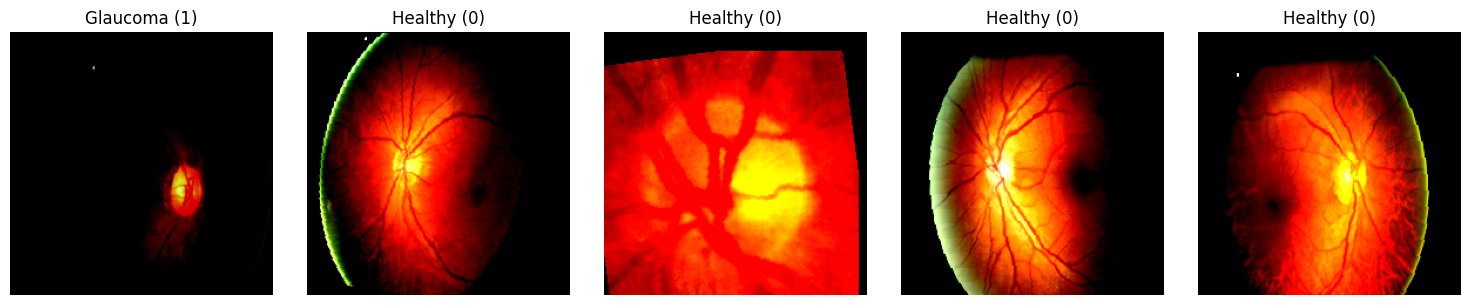

Validation set samples:


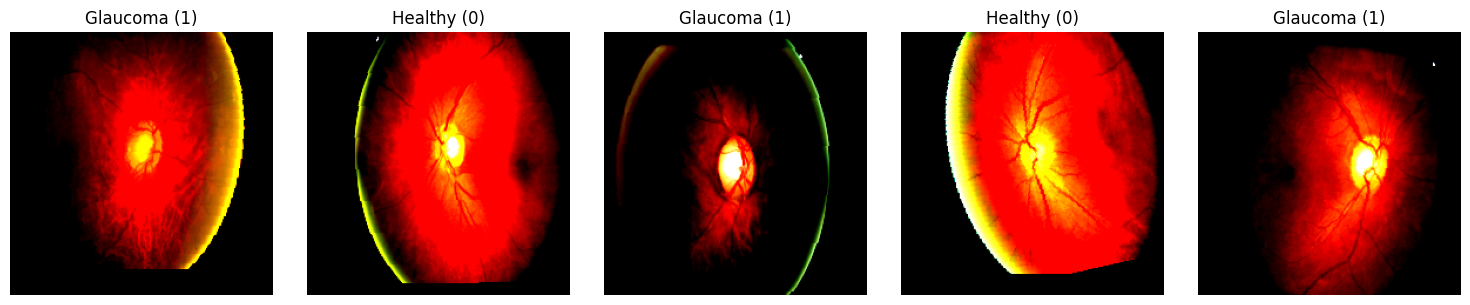

In [5]:
import matplotlib.pyplot as plt
import torch

# Label mapping
classes = ['Healthy (0)', 'Glaucoma (1)']

def show_samples(loader, num_samples=5):
    """
    Display sample RGB images from a DataLoader in a grid.
    """
    images, labels = next(iter(loader))  # get one batch
    num_samples = min(num_samples, len(images))
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu()  # (C, H, W) -> (H, W, C)
        label = labels[i].item()
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show samples from training and validation sets
print("Training set samples:")
show_samples(train_loader, num_samples=5)

print("Validation set samples:")
show_samples(val_loader, num_samples=5)


# Inception/GoogLeNet Model Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ==================== INCEPTION MODULE ====================

class InceptionModule(nn.Module):
    """
    Inception module with multiple parallel convolutional paths
    """
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        
        # 1x1 convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 -> 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 -> 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(inplace=True)
        )
        
        # MaxPool -> 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        # Concatenate all branches along channel dimension
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

# ==================== AUXILIARY CLASSIFIER ====================

class AuxiliaryClassifier(nn.Module):
    """
    Auxiliary classifier for intermediate supervision (helps with gradient flow)
    """
    def __init__(self, in_channels, num_classes):
        super(AuxiliaryClassifier, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ==================== SQUEEZE-EXCITATION BLOCK ====================

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# ==================== ENHANCED INCEPTION/GOOGLENET ====================

class EnhancedInception(nn.Module):
    """
    Enhanced GoogLeNet/Inception v1 with modern improvements:
    - Batch Normalization
    - SE blocks for attention
    - Dropout for regularization
    - Auxiliary classifiers for better gradient flow
    """
    def __init__(self, num_classes=2, in_channels=3, use_se=True, use_aux=True, dropout_rate=0.4):
        super(EnhancedInception, self).__init__()
        self.use_aux = use_aux
        self.use_se = use_se
        
        # Initial layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Inception modules
        # Inception 3a
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.se3a = SEBlock(256) if use_se else nn.Identity()
        
        # Inception 3b
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.se3b = SEBlock(480) if use_se else nn.Identity()
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Inception 4a
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.se4a = SEBlock(512) if use_se else nn.Identity()
        
        # First auxiliary classifier
        if use_aux:
            self.aux1 = AuxiliaryClassifier(512, num_classes)
        
        # Inception 4b
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.se4b = SEBlock(512) if use_se else nn.Identity()
        
        # Inception 4c
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.se4c = SEBlock(512) if use_se else nn.Identity()
        
        # Inception 4d
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.se4d = SEBlock(528) if use_se else nn.Identity()
        
        # Second auxiliary classifier
        if use_aux:
            self.aux2 = AuxiliaryClassifier(528, num_classes)
        
        # Inception 4e
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.se4e = SEBlock(832) if use_se else nn.Identity()
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Inception 5a
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.se5a = SEBlock(832) if use_se else nn.Identity()
        
        # Inception 5b
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)
        self.se5b = SEBlock(1024) if use_se else nn.Identity()
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(1024, num_classes)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial convolutions
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Inception 3
        x = self.inception3a(x)
        x = self.se3a(x)
        x = self.inception3b(x)
        x = self.se3b(x)
        x = self.maxpool3(x)
        
        # Inception 4a
        x = self.inception4a(x)
        x = self.se4a(x)
        
        # First auxiliary output
        if self.training and self.use_aux:
            aux1 = self.aux1(x)
        else:
            aux1 = None
        
        # Inception 4b, 4c, 4d
        x = self.inception4b(x)
        x = self.se4b(x)
        x = self.inception4c(x)
        x = self.se4c(x)
        x = self.inception4d(x)
        x = self.se4d(x)
        
        # Second auxiliary output
        if self.training and self.use_aux:
            aux2 = self.aux2(x)
        else:
            aux2 = None
        
        # Inception 4e
        x = self.inception4e(x)
        x = self.se4e(x)
        x = self.maxpool4(x)
        
        # Inception 5
        x = self.inception5a(x)
        x = self.se5a(x)
        x = self.inception5b(x)
        x = self.se5b(x)
        
        # Final classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        if self.training and self.use_aux:
            return x, aux1, aux2
        else:
            return x

# ==================== EXAMPLE USAGE ====================

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize model
    model = EnhancedInception(
        num_classes=2, 
        in_channels=3, 
        use_se=True, 
        use_aux=True,
        dropout_rate=0.4
    ).to(device)
    
    print("="*70)
    print("Enhanced Inception (GoogLeNet) Model")
    print("="*70)
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print("="*70)
    
    # Test forward pass
    model.train()
    dummy_input = torch.randn(4, 3, 224, 224).to(device)
    output, aux1, aux2 = model(dummy_input)
    
    print(f"\nTraining mode (with auxiliary outputs):")
    print(f"  Main output shape: {output.shape}")
    print(f"  Aux1 output shape: {aux1.shape}")
    print(f"  Aux2 output shape: {aux2.shape}")
    
    # Test evaluation mode
    model.eval()
    with torch.no_grad():
        output = model(dummy_input)
    print(f"\nEvaluation mode:")
    print(f"  Output shape: {output.shape}")
    print("="*70)

Enhanced Inception (GoogLeNet) Model
Total parameters: 10,798,774
Trainable parameters: 10,798,774

Training mode (with auxiliary outputs):
  Main output shape: torch.Size([4, 2])
  Aux1 output shape: torch.Size([4, 2])
  Aux2 output shape: torch.Size([4, 2])

Evaluation mode:
  Output shape: torch.Size([4, 2])


# Multi GPU Setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedInception(num_classes=2).to(device)

# Use all available GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


Using 2 GPUs


# Training Loop

🚀 Enhanced Inception (GoogLeNet) Training for Glaucoma Detection
📱 Device: cuda
🎮 GPU: Tesla T4
💾 GPU Memory: 15.83 GB
📊 Total parameters: 10,798,774
🔥 Using 2 GPUs with DataParallel
⚙️  Training Configuration:
   • Epochs: 101
   • Initial LR: 0.001
   • Batch Size: 32
   • Use Auxiliary Classifiers: True
   • Use SE Blocks: True
   • Early Stopping Patience: 20


Epoch [  1/101] Train: Loss=0.9650, Acc=0.7123 | Val: Loss=0.5467, Acc=0.7493 | LR=0.000976 ✅ NEW BEST!


Epoch [  2/101] Train: Loss=0.9002, Acc=0.7497 | Val: Loss=0.4980, Acc=0.7707 | LR=0.000905 ✅ NEW BEST!


Epoch [  3/101] Train: Loss=0.8714, Acc=0.7417 | Val: Loss=0.5538, Acc=0.7067 | LR=0.000794 


Epoch [  4/101] Train: Loss=0.8845, Acc=0.7523 | Val: Loss=0.4963, Acc=0.7813 | LR=0.000655 ✅ NEW BEST!


Epoch [  5/101] Train: Loss=0.8153, Acc=0.7777 | Val: Loss=0.5788, Acc=0.7360 | LR=0.000501 


Epoch [  6/101] Train: Loss=0.7531, Acc=0.7864 | Val: Loss=0.4519, Acc=0.7920 | LR=0.000346 ✅ NEW BEST!


Epoch [  7/101] Train: Loss=0.7280, Acc=0.7964 | Val: Loss=0.5178, Acc=0.7040 | LR=0.000207 


Epoch [  8/101] Train: Loss=0.6992, Acc=0.8064 | Val: Loss=0.4094, Acc=0.8133 | LR=0.000096 ✅ NEW BEST!


Epoch [  9/101] Train: Loss=0.6572, Acc=0.8071 | Val: Loss=0.3950, Acc=0.8160 | LR=0.000025 ✅ NEW BEST!


Epoch [ 10/101] Train: Loss=0.6618, Acc=0.8178 | Val: Loss=0.4107, Acc=0.8240 | LR=0.001000 ✅ NEW BEST!


Epoch [ 11/101] Train: Loss=0.7537, Acc=0.7904 | Val: Loss=0.5070, Acc=0.6747 | LR=0.000994 


Epoch [ 12/101] Train: Loss=0.7627, Acc=0.7824 | Val: Loss=0.6238, Acc=0.7253 | LR=0.000976 


Epoch [ 13/101] Train: Loss=0.7550, Acc=0.7924 | Val: Loss=0.4739, Acc=0.7653 | LR=0.000946 


Epoch [ 14/101] Train: Loss=0.7280, Acc=0.8044 | Val: Loss=0.4406, Acc=0.8160 | LR=0.000905 


Epoch [ 15/101] Train: Loss=0.7364, Acc=0.8104 | Val: Loss=0.4258, Acc=0.8053 | LR=0.000854 


Epoch [ 16/101] Train: Loss=0.7212, Acc=0.7984 | Val: Loss=0.3954, Acc=0.7973 | LR=0.000794 


Epoch [ 17/101] Train: Loss=0.6749, Acc=0.8104 | Val: Loss=0.4232, Acc=0.8160 | LR=0.000727 


Epoch [ 18/101] Train: Loss=0.6655, Acc=0.8158 | Val: Loss=0.4206, Acc=0.8027 | LR=0.000655 


Epoch [ 19/101] Train: Loss=0.6654, Acc=0.8184 | Val: Loss=0.4153, Acc=0.7920 | LR=0.000579 


Epoch [ 20/101] Train: Loss=0.6439, Acc=0.8164 | Val: Loss=0.3753, Acc=0.8320 | LR=0.000501 ✅ NEW BEST!


Epoch [ 21/101] Train: Loss=0.6244, Acc=0.8264 | Val: Loss=0.3801, Acc=0.8347 | LR=0.000422 ✅ NEW BEST!


Epoch [ 22/101] Train: Loss=0.6409, Acc=0.8211 | Val: Loss=0.4148, Acc=0.8187 | LR=0.000346 


Epoch [ 23/101] Train: Loss=0.5772, Acc=0.8498 | Val: Loss=0.3703, Acc=0.8213 | LR=0.000274 


Epoch [ 24/101] Train: Loss=0.6466, Acc=0.8211 | Val: Loss=0.3454, Acc=0.8320 | LR=0.000207 


Epoch [ 25/101] Train: Loss=0.5747, Acc=0.8391 | Val: Loss=0.3582, Acc=0.8373 | LR=0.000147 ✅ NEW BEST!


Epoch [ 26/101] Train: Loss=0.5487, Acc=0.8531 | Val: Loss=0.3816, Acc=0.8213 | LR=0.000096 


Epoch [ 27/101] Train: Loss=0.5821, Acc=0.8425 | Val: Loss=0.3505, Acc=0.8373 | LR=0.000055 


Epoch [ 28/101] Train: Loss=0.5416, Acc=0.8465 | Val: Loss=0.3537, Acc=0.8427 | LR=0.000025 ✅ NEW BEST!


Epoch [ 29/101] Train: Loss=0.5371, Acc=0.8551 | Val: Loss=0.3380, Acc=0.8427 | LR=0.000007 


Epoch [ 30/101] Train: Loss=0.5471, Acc=0.8591 | Val: Loss=0.3294, Acc=0.8427 | LR=0.001000 


Epoch [ 31/101] Train: Loss=0.6626, Acc=0.8151 | Val: Loss=0.3995, Acc=0.8000 | LR=0.000998 


Epoch [ 32/101] Train: Loss=0.6264, Acc=0.8291 | Val: Loss=0.4209, Acc=0.8373 | LR=0.000994 


Epoch [ 33/101] Train: Loss=0.6647, Acc=0.8311 | Val: Loss=0.4497, Acc=0.8187 | LR=0.000986 


Epoch [ 34/101] Train: Loss=0.6511, Acc=0.8251 | Val: Loss=0.6102, Acc=0.8080 | LR=0.000976 


Epoch [ 35/101] Train: Loss=0.6368, Acc=0.8264 | Val: Loss=0.3949, Acc=0.8133 | LR=0.000962 


Epoch [ 36/101] Train: Loss=0.6539, Acc=0.8164 | Val: Loss=0.3744, Acc=0.8427 | LR=0.000946 


Epoch [ 37/101] Train: Loss=0.6294, Acc=0.8284 | Val: Loss=0.4116, Acc=0.8293 | LR=0.000926 


Epoch [ 38/101] Train: Loss=0.6051, Acc=0.8304 | Val: Loss=0.3550, Acc=0.8133 | LR=0.000905 


Epoch [ 39/101] Train: Loss=0.5866, Acc=0.8405 | Val: Loss=0.4056, Acc=0.8160 | LR=0.000880 


Epoch [ 40/101] Train: Loss=0.6136, Acc=0.8224 | Val: Loss=0.3722, Acc=0.8187 | LR=0.000854 


Epoch [ 41/101] Train: Loss=0.5971, Acc=0.8425 | Val: Loss=0.4612, Acc=0.8160 | LR=0.000825 


Epoch [ 42/101] Train: Loss=0.6045, Acc=0.8331 | Val: Loss=0.3251, Acc=0.8373 | LR=0.000794 


Epoch [ 43/101] Train: Loss=0.5731, Acc=0.8391 | Val: Loss=0.3410, Acc=0.8640 | LR=0.000761 ✅ NEW BEST!


Epoch [ 44/101] Train: Loss=0.5682, Acc=0.8431 | Val: Loss=0.3276, Acc=0.8453 | LR=0.000727 


Epoch [ 45/101] Train: Loss=0.5706, Acc=0.8391 | Val: Loss=0.3364, Acc=0.8320 | LR=0.000692 


Epoch [ 46/101] Train: Loss=0.5220, Acc=0.8518 | Val: Loss=0.4056, Acc=0.8240 | LR=0.000655 


Epoch [ 47/101] Train: Loss=0.5781, Acc=0.8545 | Val: Loss=0.3599, Acc=0.8267 | LR=0.000617 


Epoch [ 48/101] Train: Loss=0.5246, Acc=0.8672 | Val: Loss=0.3290, Acc=0.8507 | LR=0.000579 


Epoch [ 49/101] Train: Loss=0.5210, Acc=0.8605 | Val: Loss=0.3520, Acc=0.8213 | LR=0.000540 


Epoch [ 50/101] Train: Loss=0.5258, Acc=0.8565 | Val: Loss=0.3483, Acc=0.8400 | LR=0.000501 


Epoch [ 51/101] Train: Loss=0.4975, Acc=0.8678 | Val: Loss=0.3982, Acc=0.8427 | LR=0.000461 


Epoch [ 52/101] Train: Loss=0.5138, Acc=0.8678 | Val: Loss=0.3394, Acc=0.8427 | LR=0.000422 


Epoch [ 53/101] Train: Loss=0.4880, Acc=0.8732 | Val: Loss=0.3251, Acc=0.8293 | LR=0.000384 


Epoch [ 54/101] Train: Loss=0.4940, Acc=0.8805 | Val: Loss=0.3207, Acc=0.8560 | LR=0.000346 


Epoch [ 55/101] Train: Loss=0.4775, Acc=0.8685 | Val: Loss=0.3150, Acc=0.8427 | LR=0.000309 


Epoch [ 56/101] Train: Loss=0.4723, Acc=0.8772 | Val: Loss=0.3058, Acc=0.8533 | LR=0.000274 


Epoch [ 57/101] Train: Loss=0.4361, Acc=0.8818 | Val: Loss=0.3252, Acc=0.8533 | LR=0.000240 


Epoch [ 58/101] Train: Loss=0.4461, Acc=0.8919 | Val: Loss=0.3305, Acc=0.8560 | LR=0.000207 


Epoch [ 59/101] Train: Loss=0.4376, Acc=0.8885 | Val: Loss=0.3085, Acc=0.8720 | LR=0.000176 ✅ NEW BEST!


Epoch [ 60/101] Train: Loss=0.4435, Acc=0.8905 | Val: Loss=0.2961, Acc=0.8907 | LR=0.000147 ✅ NEW BEST!


Epoch [ 61/101] Train: Loss=0.4474, Acc=0.8879 | Val: Loss=0.2829, Acc=0.8613 | LR=0.000121 


Epoch [ 62/101] Train: Loss=0.3671, Acc=0.9092 | Val: Loss=0.3169, Acc=0.8533 | LR=0.000096 


Epoch [ 63/101] Train: Loss=0.4034, Acc=0.8985 | Val: Loss=0.3080, Acc=0.8480 | LR=0.000075 


Epoch [ 64/101] Train: Loss=0.4086, Acc=0.8912 | Val: Loss=0.2719, Acc=0.8747 | LR=0.000055 


Epoch [ 65/101] Train: Loss=0.3920, Acc=0.9099 | Val: Loss=0.2910, Acc=0.8720 | LR=0.000039 


Epoch [ 66/101] Train: Loss=0.3981, Acc=0.9025 | Val: Loss=0.2744, Acc=0.8933 | LR=0.000025 ✅ NEW BEST!


Epoch [ 67/101] Train: Loss=0.3930, Acc=0.8979 | Val: Loss=0.2735, Acc=0.8747 | LR=0.000015 


Epoch [ 68/101] Train: Loss=0.3812, Acc=0.9099 | Val: Loss=0.3050, Acc=0.8720 | LR=0.000007 


Epoch [ 69/101] Train: Loss=0.3753, Acc=0.9079 | Val: Loss=0.2748, Acc=0.8720 | LR=0.000003 


Epoch [ 70/101] Train: Loss=0.3600, Acc=0.9139 | Val: Loss=0.2690, Acc=0.8907 | LR=0.001000 


Epoch [ 71/101] Train: Loss=0.4799, Acc=0.8752 | Val: Loss=0.3598, Acc=0.8293 | LR=0.001000 


Epoch [ 72/101] Train: Loss=0.5434, Acc=0.8578 | Val: Loss=0.4418, Acc=0.8027 | LR=0.000998 


Epoch [ 73/101] Train: Loss=0.5039, Acc=0.8652 | Val: Loss=0.3326, Acc=0.8533 | LR=0.000997 


Epoch [ 74/101] Train: Loss=0.5198, Acc=0.8638 | Val: Loss=0.3522, Acc=0.8267 | LR=0.000994 


Epoch [ 75/101] Train: Loss=0.4845, Acc=0.8725 | Val: Loss=0.3535, Acc=0.8347 | LR=0.000990 


Epoch [ 76/101] Train: Loss=0.4927, Acc=0.8632 | Val: Loss=0.3259, Acc=0.8587 | LR=0.000986 


Epoch [ 77/101] Train: Loss=0.4667, Acc=0.8792 | Val: Loss=0.3023, Acc=0.8373 | LR=0.000981 


Epoch [ 78/101] Train: Loss=0.5115, Acc=0.8692 | Val: Loss=0.3519, Acc=0.8480 | LR=0.000976 


Epoch [ 79/101] Train: Loss=0.5073, Acc=0.8605 | Val: Loss=0.3242, Acc=0.8693 | LR=0.000969 


Epoch [ 80/101] Train: Loss=0.4753, Acc=0.8838 | Val: Loss=0.3101, Acc=0.8347 | LR=0.000962 


Epoch [ 81/101] Train: Loss=0.4889, Acc=0.8678 | Val: Loss=0.5715, Acc=0.8347 | LR=0.000954 


Epoch [ 82/101] Train: Loss=0.4766, Acc=0.8778 | Val: Loss=0.3575, Acc=0.8507 | LR=0.000946 


Epoch [ 83/101] Train: Loss=0.4633, Acc=0.8812 | Val: Loss=0.2825, Acc=0.8693 | LR=0.000936 


Epoch [ 84/101] Train: Loss=0.4619, Acc=0.8685 | Val: Loss=0.3271, Acc=0.8453 | LR=0.000926 


Epoch [ 85/101] Train: Loss=0.4526, Acc=0.8765 | Val: Loss=0.4035, Acc=0.8347 | LR=0.000916 


Epoch [ 86/101] Train: Loss=0.4704, Acc=0.8885 | Val: Loss=0.3465, Acc=0.8533 | LR=0.000905 


Epoch [ 87/101] Train: Loss=0.4712, Acc=0.8745 | Val: Loss=0.3673, Acc=0.8400 | LR=0.000893 


Epoch [ 88/101] Train: Loss=0.4600, Acc=0.8838 | Val: Loss=0.3160, Acc=0.8427 | LR=0.000880 


Epoch [ 89/101] Train: Loss=0.4295, Acc=0.8838 | Val: Loss=0.4006, Acc=0.8480 | LR=0.000867 


Epoch [ 90/101] Train: Loss=0.4365, Acc=0.8899 | Val: Loss=0.3377, Acc=0.8400 | LR=0.000854 

⚠️  Early stopping triggered at epoch 90
   Best Val Acc: 0.8933 | Best Val Loss: 0.2744

🎉 Training Complete!
   Best Validation Accuracy: 0.8933 (89.33%)
   Best Validation Loss: 0.2744
   Total Epochs: 90
📊 Training metrics saved as 'inception_training_metrics.png'


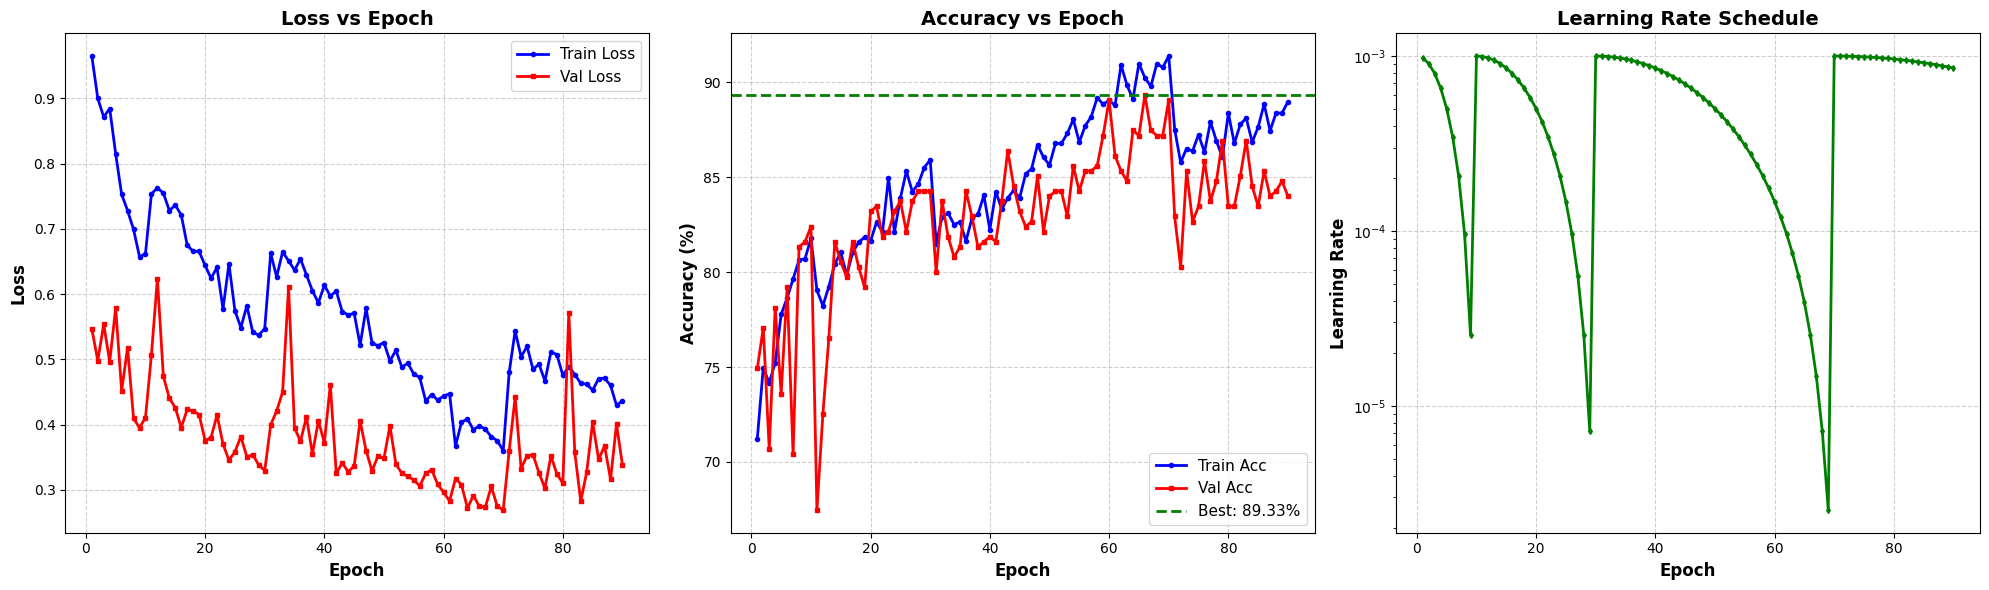


📈 Final Statistics:
   Final Train Accuracy: 0.8899 (88.99%)
   Final Val Accuracy: 0.8400 (84.00%)
   Overfitting Gap: 0.0499
   Best Epoch: 66


In [8]:
# ==================== COMPLETE INCEPTION TRAINING SCRIPT ====================
# Copy this entire script to a Kaggle notebook cell

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


# ==================== AUXILIARY CLASSES ====================

class InceptionLoss(nn.Module):
    """Custom loss for Inception with auxiliary classifiers"""
    def __init__(self, aux_weight=0.3):
        super(InceptionLoss, self).__init__()
        self.aux_weight = aux_weight
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, outputs, labels):
        if isinstance(outputs, tuple):
            main_output, aux1_output, aux2_output = outputs
            main_loss = self.criterion(main_output, labels)
            aux1_loss = self.criterion(aux1_output, labels)
            aux2_loss = self.criterion(aux2_output, labels)
            total_loss = main_loss + self.aux_weight * (aux1_loss + aux2_loss)
            return total_loss
        else:
            return self.criterion(outputs, labels)

class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing for better generalization"""
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=15, min_delta=0.0001, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_value = None
        self.early_stop = False
    
    def __call__(self, metric):
        if self.best_value is None:
            self.best_value = metric
            return False
        
        if self.mode == 'min':
            improved = metric < (self.best_value - self.min_delta)
        else:
            improved = metric > (self.best_value + self.min_delta)
        
        if improved:
            self.best_value = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop

# ==================== CONFIGURATION ====================

# Model settings
NUM_CLASSES = 2
IN_CHANNELS = 3
USE_SE = True
USE_AUX = True
DROPOUT_RATE = 0.4

# Training settings
NUM_EPOCHS = 101
INITIAL_LR = 0.001
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 32
AUX_WEIGHT = 0.3
GRADIENT_CLIP = 1.0
EARLY_STOPPING_PATIENCE = 20

print("="*70)
print("🚀 Enhanced Inception (GoogLeNet) Training for Glaucoma Detection")
print("="*70)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Device: {device}")

if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Initialize model
model = EnhancedInception(
    num_classes=NUM_CLASSES,
    in_channels=IN_CHANNELS,
    use_se=USE_SE,
    use_aux=USE_AUX,
    dropout_rate=DROPOUT_RATE
).to(device)

print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

print("="*70)

# ==================== TRAINING SETUP ====================

# Loss function
if USE_AUX:
    criterion = InceptionLoss(aux_weight=AUX_WEIGHT)
else:
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=INITIAL_LR,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

# Mixed precision
scaler = torch.amp.GradScaler('cuda')

# Early stopping
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, min_delta=0.0001, mode='min')

# Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
learning_rates = []
best_val_acc = 0.0
best_val_loss = float('inf')

print("⚙️  Training Configuration:")
print(f"   • Epochs: {NUM_EPOCHS}")
print(f"   • Initial LR: {INITIAL_LR}")
print(f"   • Batch Size: {BATCH_SIZE}")
print(f"   • Use Auxiliary Classifiers: {USE_AUX}")
print(f"   • Use SE Blocks: {USE_SE}")
print(f"   • Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print("="*70)

# ==================== TRAINING LOOP ====================

for epoch in range(NUM_EPOCHS):
    # TRAINING
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
    
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        
        # Get predictions from main output
        if isinstance(outputs, tuple):
            main_output = outputs[0]
        else:
            main_output = outputs
        
        _, predicted = torch.max(main_output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
    
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*val_correct/val_total:.2f}%'
            })
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, "best_inception_glaucoma.pth")
        improvement = "✅ NEW BEST!"
    else:
        improvement = ""
    
    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] "
          f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f} | "
          f"LR={current_lr:.6f} {improvement}")
    
    # Early stopping
    if early_stopping(val_loss):
        print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        print(f"   Best Val Acc: {best_val_acc:.4f} | Best Val Loss: {best_val_loss:.4f}")
        break

# ==================== SAVE FINAL MODEL ====================

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
}, "final_inception_glaucoma.pth")

print("\n" + "="*70)
print("🎉 Training Complete!")
print(f"   Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Best Validation Loss: {best_val_loss:.4f}")
print(f"   Total Epochs: {len(train_losses)}")
print("="*70)

# ==================== VISUALIZATION ====================

fig = plt.figure(figsize=(20, 6))

# Loss
ax1 = plt.subplot(1, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o', markersize=3)
ax1.plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2, marker='s', markersize=3)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.6)

# Accuracy
ax2 = plt.subplot(1, 3, 2)
ax2.plot(epochs_range, [acc*100 for acc in train_accuracies], 'b-', label='Train Acc', linewidth=2, marker='o', markersize=3)
ax2.plot(epochs_range, [acc*100 for acc in val_accuracies], 'r-', label='Val Acc', linewidth=2, marker='s', markersize=3)
ax2.axhline(y=best_val_acc*100, color='g', linestyle='--', linewidth=2, label=f'Best: {best_val_acc*100:.2f}%')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.6)

# Learning rate
ax3 = plt.subplot(1, 3, 3)
ax3.plot(epochs_range, learning_rates, 'g-', linewidth=2, marker='d', markersize=3)
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('inception_training_metrics.png', dpi=300, bbox_inches='tight')
print("📊 Training metrics saved as 'inception_training_metrics.png'")
plt.show()

print("\n📈 Final Statistics:")
print(f"   Final Train Accuracy: {train_accuracies[-1]:.4f} ({train_accuracies[-1]*100:.2f}%)")
print(f"   Final Val Accuracy: {val_accuracies[-1]:.4f} ({val_accuracies[-1]*100:.2f}%)")
print(f"   Overfitting Gap: {(train_accuracies[-1] - val_accuracies[-1]):.4f}")
print(f"   Best Epoch: {val_accuracies.index(max(val_accuracies)) + 1}")
print("="*70)

# Load & Test Model

🔍 Enhanced Inception Model Evaluation
📱 Device: cuda
📂 Loading model from: best_inception_glaucoma.pth
   Epoch: 66
   Val Accuracy: 0.8933
   Val Loss: 0.2744
✅ Model loaded successfully!

🧪 Running evaluation on validation set...


Evaluating: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it]



✅ Overall Accuracy: 86.93%

📊 Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Healthy     0.8745    0.9099    0.8918       222
    Glaucoma     0.8611    0.8105    0.8350       153

    accuracy                         0.8693       375
   macro avg     0.8678    0.8602    0.8634       375
weighted avg     0.8690    0.8693    0.8687       375


💾 Confusion matrix saved as 'inception_confusion_matrix.png'


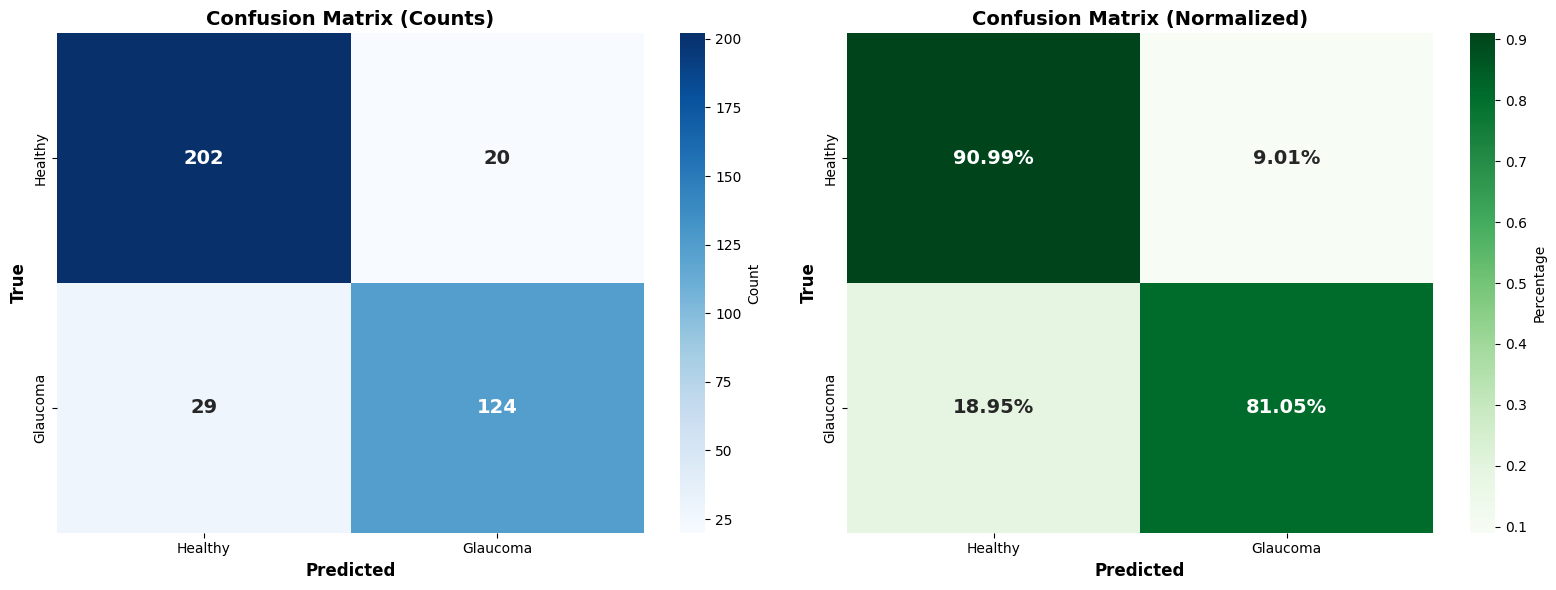


📈 Per-Class Performance:
----------------------------------------------------------------------
   Healthy     : Accuracy =  90.99% | Count =  222
   Glaucoma    : Accuracy =  81.05% | Count =  153
💾 ROC and PR curves saved as 'inception_roc_pr_curves.png'


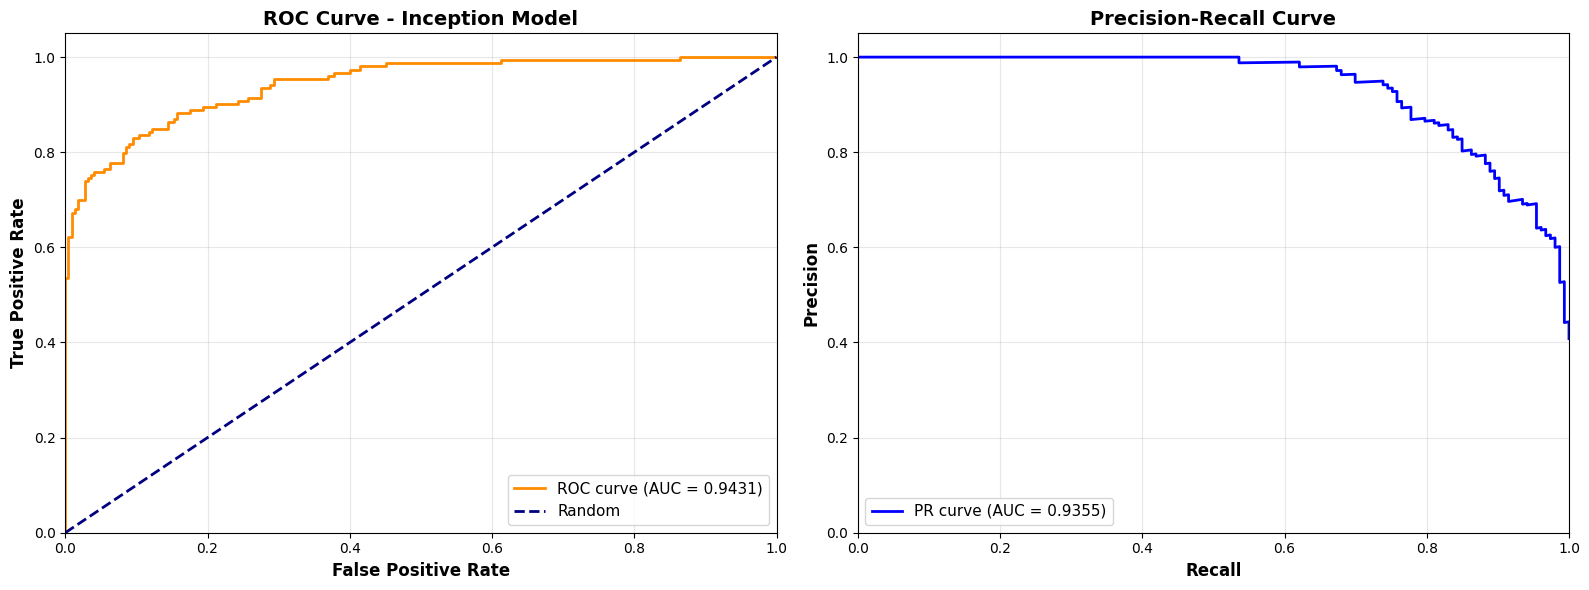


🎯 Optimal Classification Threshold:
   Threshold: 0.4676
   True Positive Rate (Sensitivity): 0.8301
   False Positive Rate: 0.0946
   Specificity: 0.9054

📊 Medical Performance Metrics:
   Sensitivity (Recall): 0.8105 (81.05%)
   Specificity: 0.9099 (90.99%)
   Precision (PPV): 0.8611 (86.11%)
   F1-Score: 0.8350
   ROC-AUC: 0.9431

✅ Evaluation Complete!


In [9]:
# ==================== COMPLETE INCEPTION EVALUATION SCRIPT ====================

import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from tqdm import tqdm

print("="*70)
print("🔍 Enhanced Inception Model Evaluation")
print("="*70)

# Define class names
classes = ['Healthy', 'Glaucoma']

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Device: {device}")

# ==================== LOAD MODEL ====================

# Initialize model (must match training configuration)
model = EnhancedInception(
    num_classes=2,
    in_channels=3,
    use_se=True,
    use_aux=False,  # Set to False for evaluation (no auxiliary outputs)
    dropout_rate=0.4
).to(device)

# Load checkpoint
checkpoint_path = "best_inception_glaucoma.pth"
print(f"📂 Loading model from: {checkpoint_path}")

try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        print(f"   Epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"   Val Accuracy: {checkpoint.get('val_acc', 'N/A'):.4f}")
        print(f"   Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
    else:
        state_dict = checkpoint
    
    # Remove 'module.' prefix if model was trained with DataParallel
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "")
        new_state_dict[name] = v
    
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    print("✅ Model loaded successfully!")
    
except FileNotFoundError:
    print(f"❌ Error: Model file '{checkpoint_path}' not found!")
    print("   Please ensure you've trained the model first.")
    exit()
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

print("="*70)

# ==================== EVALUATION ====================

all_preds = []
all_labels = []
all_probs = []

print("\n🧪 Running evaluation on validation set...")

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        
        # Get predictions
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        
        # Calculate accuracy
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# ==================== METRICS ====================

overall_accuracy = correct / total
print(f"\n✅ Overall Accuracy: {overall_accuracy * 100:.2f}%")
print("="*70)

# Classification Report
print("\n📊 Detailed Classification Report:")
print("-"*70)
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# ==================== CONFUSION MATRIX ====================

cm = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix (Count)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=axes[0],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_xlabel("Predicted", fontsize=12, fontweight='bold')
axes[0].set_ylabel("True", fontsize=12, fontweight='bold')
axes[0].set_title("Confusion Matrix (Counts)", fontsize=14, fontweight='bold')

# Confusion Matrix (Normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'}, ax=axes[1],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_xlabel("Predicted", fontsize=12, fontweight='bold')
axes[1].set_ylabel("True", fontsize=12, fontweight='bold')
axes[1].set_title("Confusion Matrix (Normalized)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('inception_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n💾 Confusion matrix saved as 'inception_confusion_matrix.png'")
plt.show()

# ==================== PER-CLASS METRICS ====================

print("\n📈 Per-Class Performance:")
print("-"*70)
cm_diag = np.diag(cm)
class_counts = cm.sum(axis=1)

for i, cls in enumerate(classes):
    class_acc = cm_diag[i] / class_counts[i] * 100
    print(f"   {cls:12s}: Accuracy = {class_acc:6.2f}% | Count = {class_counts[i]:4d}")

# ==================== ROC AND PR CURVES ====================

# ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curve - Inception Model', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('inception_roc_pr_curves.png', dpi=300, bbox_inches='tight')
print("💾 ROC and PR curves saved as 'inception_roc_pr_curves.png'")
plt.show()

# ==================== OPTIMAL THRESHOLD ====================

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

print("\n🎯 Optimal Classification Threshold:")
print(f"   Threshold: {optimal_threshold:.4f}")
print(f"   True Positive Rate (Sensitivity): {optimal_tpr:.4f}")
print(f"   False Positive Rate: {optimal_fpr:.4f}")
print(f"   Specificity: {1-optimal_fpr:.4f}")

# ==================== MEDICAL METRICS ====================

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_score = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0

print("\n📊 Medical Performance Metrics:")
print(f"   Sensitivity (Recall): {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"   Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f"   Precision (PPV): {precision_val:.4f} ({precision_val*100:.2f}%)")
print(f"   F1-Score: {f1_score:.4f}")
print(f"   ROC-AUC: {roc_auc:.4f}")

print("\n" + "="*70)
print("✅ Evaluation Complete!")
print("="*70)

# Visualization on overall and glucoma only

🔬 Inception Model - Glaucoma-Specific Performance Analysis
📂 Loading model from: best_inception_glaucoma.pth
✅ Model loaded successfully!

🔍 Collecting glaucoma samples from validation set...


Processing: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



📊 Inception Model - Class-Specific Performance:
🟢 Healthy Class:
   Total samples: 222
   Correct predictions: 203
   Accuracy: 91.44%
   Sensitivity for Healthy: 91.44%

🔴 Glaucoma Class:
   Total samples: 153
   Correct predictions: 126
   Accuracy: 82.35% ⭐
   Sensitivity for Glaucoma (Recall): 82.35%

📈 Overall Accuracy: 87.73%

🎯 Critical Medical Metrics:
   True Positives (Detected Glaucoma): 126
   False Negatives (Missed Glaucoma): 27 ⚠️
   False Positives (False Alarms): 19
   True Negatives (Correct Healthy): 203
   Specificity: 91.44%
   Precision (PPV): 86.90%

🖼️  Visualizing glaucoma predictions...

✅ Correctly Identified Glaucoma Cases (4 samples):


/tmp/ipykernel_19/3042429888.py:195: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/3042429888.py:196: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.savefig('inception_glaucoma_correct.png', dpi=300, bbox_inches='tight')


💾 Saved as 'inception_glaucoma_correct.png'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


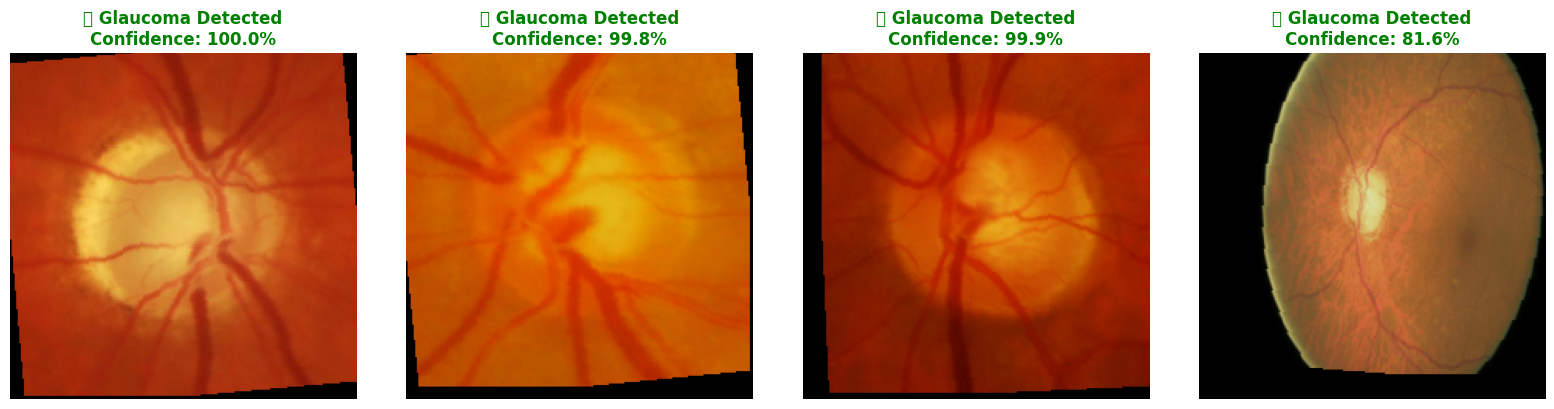


❌ Missed Glaucoma Cases (4 samples):
⚠️  These are critical false negatives that need attention!


/tmp/ipykernel_19/3042429888.py:228: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/3042429888.py:229: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.savefig('inception_glaucoma_missed.png', dpi=300, bbox_inches='tight')


💾 Saved as 'inception_glaucoma_missed.png'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


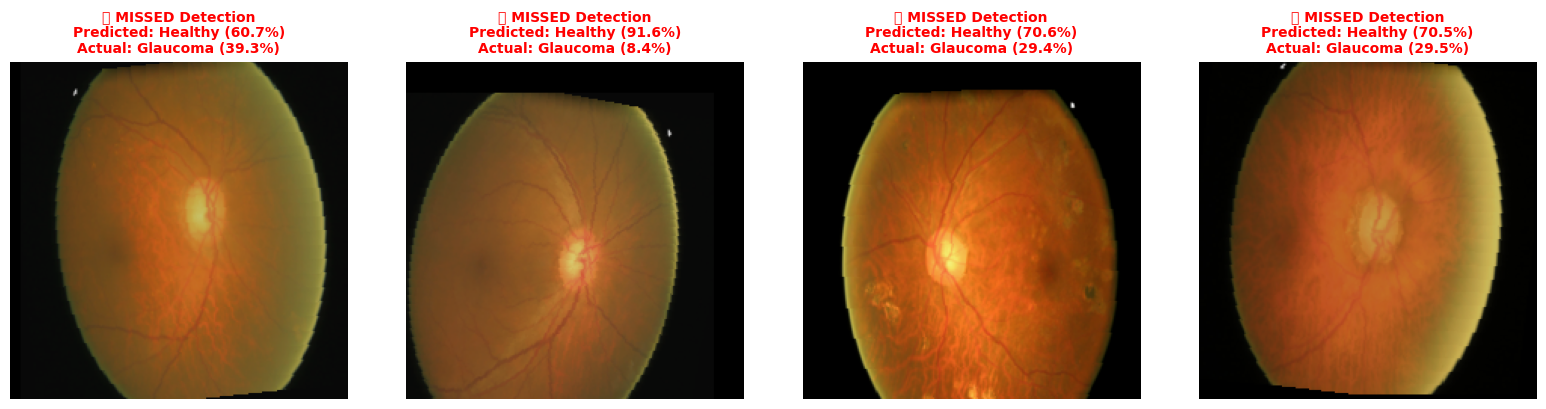


📊 Analyzing prediction confidence for glaucoma samples...
💾 Confidence distribution saved as 'inception_glaucoma_confidence.png'


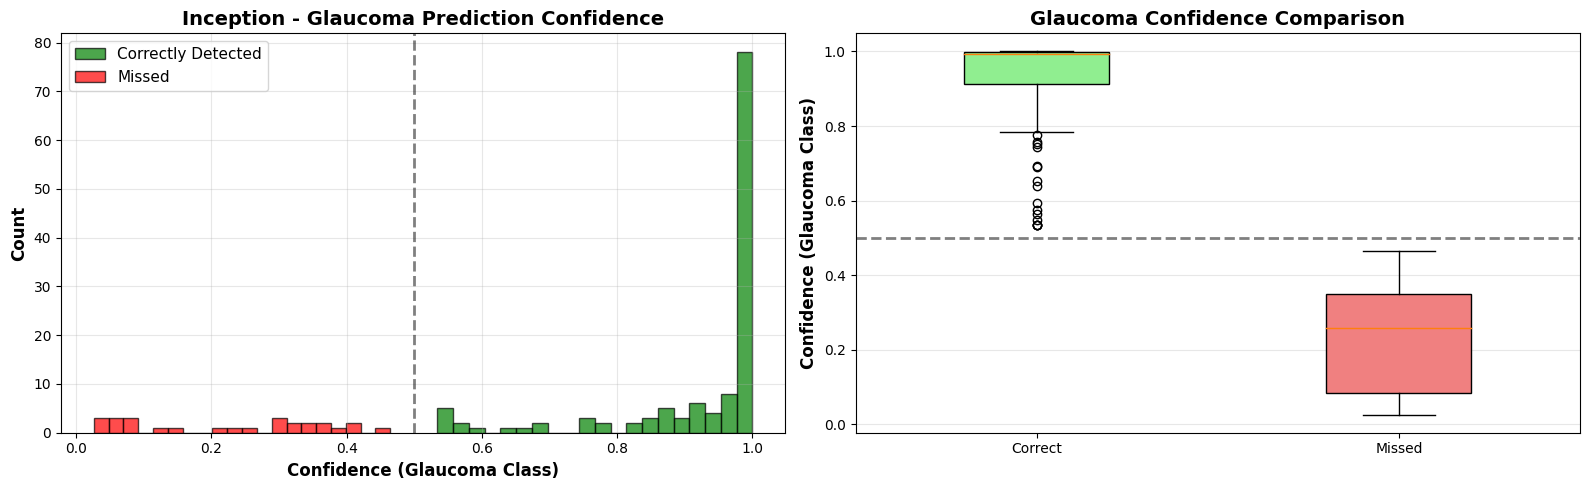


📈 Confidence Statistics for Correct Glaucoma Detections:
   Mean confidence: 0.9270 (92.70%)
   Std deviation: 0.1252
   Min confidence: 0.5343 (53.43%)
   Max confidence: 1.0000

⚠️  Confidence Statistics for Missed Glaucoma Cases:
   Mean confidence: 0.2284 (22.84%)
   These cases were close to the decision boundary (0.5)

🎯 Analyzing optimal confidence threshold for glaucoma detection...
💾 Threshold analysis saved as 'inception_threshold_analysis.png'


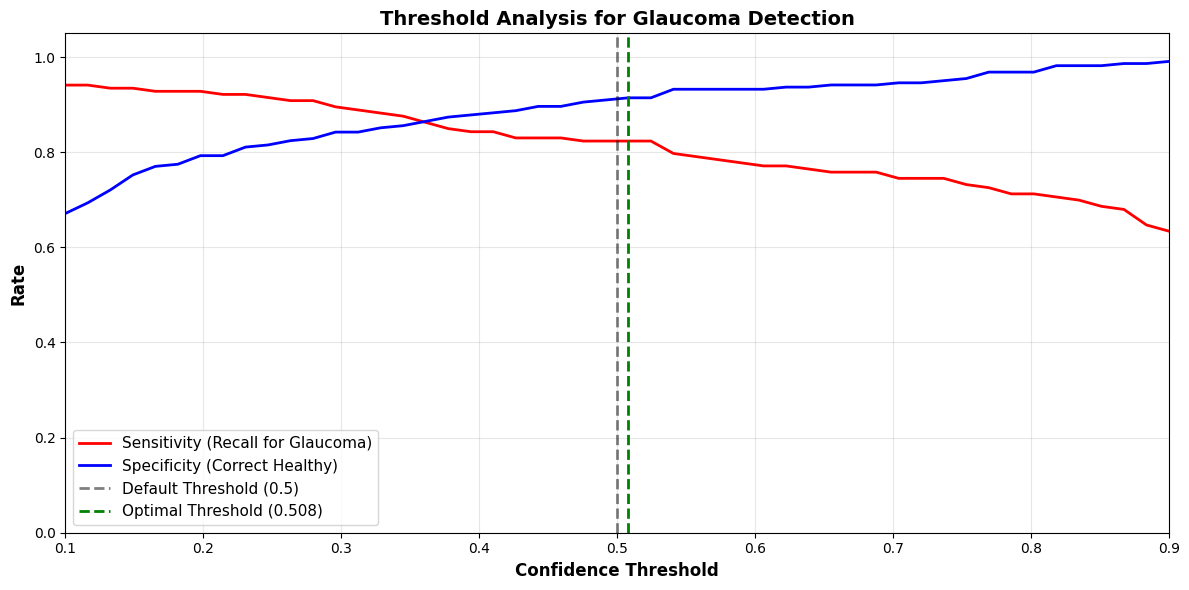


🎯 Optimal Threshold Recommendation:
   Optimal threshold: 0.5082
   Sensitivity at optimal: 0.8235 (82.35%)
   Specificity at optimal: 0.9144 (91.44%)

   At default threshold (0.5):
   Sensitivity: 0.8235 (82.35%)
   Specificity: 0.9099 (90.99%)

✅ Glaucoma-Specific Analysis Complete!

📋 SUMMARY REPORT - Inception Model for Glaucoma Detection

🔬 Dataset Statistics:
   Total validation samples: 375
   Glaucoma samples: 153 (40.8%)
   Healthy samples: 222 (59.2%)

🎯 Model Performance:
   Overall Accuracy: 87.73%
   Glaucoma Detection Rate (Sensitivity): 82.35%
   Healthy Detection Rate (Specificity): 91.44%

⚠️  Critical for Medical Use:
   Correctly detected glaucoma: 126/153
   Missed glaucoma cases (False Negatives): 27
   → 17.65% of glaucoma cases were missed

💡 Recommendation: Review missed cases to improve model

📊 Generated Files:
   • inception_glaucoma_correct.png - Correctly detected cases
   • inception_glaucoma_missed.png - Missed cases (for review)
   • inception_glaucoma

In [10]:
# ==================== INCEPTION GLAUCOMA-SPECIFIC ANALYSIS ====================

import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import OrderedDict
from tqdm import tqdm

# Import the EnhancedInception model
# IMPORTANT: Make sure EnhancedInception class is defined in a previous cell

# ==================== 🔧 EDIT HERE: YOUR DATA LOADER ====================
# TODO: Make sure val_loader is defined from your data loading cell
# ==================== END EDIT SECTION ====================

print("="*70)
print("🔬 Inception Model - Glaucoma-Specific Performance Analysis")
print("="*70)

# Define class names
classes = ['Healthy', 'Glaucoma']

# ==================== LOAD MODEL ====================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model (must match training configuration)
model = EnhancedInception(
    num_classes=2,
    in_channels=3,
    use_se=True,
    use_aux=False,  # Set to False for evaluation
    dropout_rate=0.4
).to(device)

# Load checkpoint
checkpoint_path = "best_inception_glaucoma.pth"
print(f"📂 Loading model from: {checkpoint_path}")

try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    # Remove 'module.' prefix if model was trained with DataParallel
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "")
        new_state_dict[name] = v
    
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    print("✅ Model loaded successfully!\n")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

# ==================== HELPER FUNCTIONS ====================

def denormalize_image(img):
    """Denormalize image for visualization"""
    img = img.clone()
    
    # Try ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    
    return img.permute(1, 2, 0).cpu().numpy()

# ==================== COLLECT GLAUCOMA SAMPLES ====================

print("🔍 Collecting glaucoma samples from validation set...")

glaucoma_images = []
glaucoma_predictions = []
glaucoma_probabilities = []
glaucoma_correct = []

healthy_images = []
healthy_predictions = []
healthy_probabilities = []
healthy_correct = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Processing"):
        images_device = images.to(device)
        labels_device = labels.to(device)
        
        outputs = model(images_device)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        # Separate by true label
        for i in range(images.size(0)):
            if labels[i].item() == 1:  # Glaucoma
                glaucoma_images.append(images[i])
                glaucoma_predictions.append(preds[i])
                glaucoma_probabilities.append(probs[i])
                glaucoma_correct.append(preds[i].item() == 1)
            else:  # Healthy
                healthy_images.append(images[i])
                healthy_predictions.append(preds[i])
                healthy_probabilities.append(probs[i])
                healthy_correct.append(preds[i].item() == 0)

total_glaucoma = len(glaucoma_images)
correct_glaucoma = sum(glaucoma_correct)
total_healthy = len(healthy_images)
correct_healthy = sum(healthy_correct)

# ==================== CALCULATE METRICS ====================

glaucoma_accuracy = correct_glaucoma / total_glaucoma * 100 if total_glaucoma > 0 else 0
healthy_accuracy = correct_healthy / total_healthy * 100 if total_healthy > 0 else 0
overall_accuracy = (correct_glaucoma + correct_healthy) / (total_glaucoma + total_healthy) * 100

print("\n" + "="*70)
print("📊 Inception Model - Class-Specific Performance:")
print("="*70)
print(f"🟢 Healthy Class:")
print(f"   Total samples: {total_healthy}")
print(f"   Correct predictions: {correct_healthy}")
print(f"   Accuracy: {healthy_accuracy:.2f}%")
print(f"   Sensitivity for Healthy: {healthy_accuracy:.2f}%")
print(f"\n🔴 Glaucoma Class:")
print(f"   Total samples: {total_glaucoma}")
print(f"   Correct predictions: {correct_glaucoma}")
print(f"   Accuracy: {glaucoma_accuracy:.2f}% ⭐")
print(f"   Sensitivity for Glaucoma (Recall): {glaucoma_accuracy:.2f}%")
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}%")

# Calculate additional metrics
if total_glaucoma > 0 and total_healthy > 0:
    false_negatives = total_glaucoma - correct_glaucoma
    false_positives = total_healthy - correct_healthy
    true_positives = correct_glaucoma
    true_negatives = correct_healthy
    
    specificity = true_negatives / (true_negatives + false_positives) * 100 if (true_negatives + false_positives) > 0 else 0
    precision = true_positives / (true_positives + false_positives) * 100 if (true_positives + false_positives) > 0 else 0
    
    print(f"\n🎯 Critical Medical Metrics:")
    print(f"   True Positives (Detected Glaucoma): {true_positives}")
    print(f"   False Negatives (Missed Glaucoma): {false_negatives} ⚠️")
    print(f"   False Positives (False Alarms): {false_positives}")
    print(f"   True Negatives (Correct Healthy): {true_negatives}")
    print(f"   Specificity: {specificity:.2f}%")
    print(f"   Precision (PPV): {precision:.2f}%")

print("="*70)

# ==================== VISUALIZE GLAUCOMA PREDICTIONS ====================

if total_glaucoma > 0:
    print(f"\n🖼️  Visualizing glaucoma predictions...")
    
    # Select samples: correct and incorrect
    correct_indices = [i for i, c in enumerate(glaucoma_correct) if c]
    incorrect_indices = [i for i, c in enumerate(glaucoma_correct) if not c]
    
    num_correct_to_show = min(4, len(correct_indices))
    num_incorrect_to_show = min(4, len(incorrect_indices))
    
    # CORRECT GLAUCOMA PREDICTIONS
    if num_correct_to_show > 0:
        print(f"\n✅ Correctly Identified Glaucoma Cases ({num_correct_to_show} samples):")
        
        fig, axes = plt.subplots(1, num_correct_to_show, figsize=(num_correct_to_show * 4, 4))
        if num_correct_to_show == 1:
            axes = [axes]
        
        selected_indices = random.sample(correct_indices, num_correct_to_show)
        
        for idx, i in enumerate(selected_indices):
            img = denormalize_image(glaucoma_images[i])
            prob = glaucoma_probabilities[i][1].item()  # Probability of Glaucoma
            
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f"✅ Glaucoma Detected\nConfidence: {prob*100:.1f}%",
                               fontsize=12, fontweight='bold', color='green')
            
            for spine in axes[idx].spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(4)
                spine.set_visible(True)
        
        plt.tight_layout()
        plt.savefig('inception_glaucoma_correct.png', dpi=300, bbox_inches='tight')
        print("💾 Saved as 'inception_glaucoma_correct.png'")
        plt.show()
    else:
        print("\n🎉 Perfect! All glaucoma cases detected correctly!")
    
    # INCORRECT GLAUCOMA PREDICTIONS (Missed Cases)
    if num_incorrect_to_show > 0:
        print(f"\n❌ Missed Glaucoma Cases ({num_incorrect_to_show} samples):")
        print(f"⚠️  These are critical false negatives that need attention!")
        
        fig, axes = plt.subplots(1, num_incorrect_to_show, figsize=(num_incorrect_to_show * 4, 4))
        if num_incorrect_to_show == 1:
            axes = [axes]
        
        selected_indices = random.sample(incorrect_indices, num_incorrect_to_show)
        
        for idx, i in enumerate(selected_indices):
            img = denormalize_image(glaucoma_images[i])
            prob_healthy = glaucoma_probabilities[i][0].item()  # Misclassified as Healthy
            prob_glaucoma = glaucoma_probabilities[i][1].item()
            
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f"❌ MISSED Detection\nPredicted: Healthy ({prob_healthy*100:.1f}%)\nActual: Glaucoma ({prob_glaucoma*100:.1f}%)",
                               fontsize=10, fontweight='bold', color='red')
            
            for spine in axes[idx].spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(4)
                spine.set_visible(True)
        
        plt.tight_layout()
        plt.savefig('inception_glaucoma_missed.png', dpi=300, bbox_inches='tight')
        print("💾 Saved as 'inception_glaucoma_missed.png'")
        plt.show()
    else:
        print("\n🎉 Excellent! No missed glaucoma cases!")
else:
    print("\n⚠️ No glaucoma samples found in the validation set!")

# ==================== CONFIDENCE DISTRIBUTION FOR GLAUCOMA ====================

print("\n📊 Analyzing prediction confidence for glaucoma samples...")

if total_glaucoma > 0:
    glaucoma_probs = np.array([p[1].item() for p in glaucoma_probabilities])  # Glaucoma class probabilities
    glaucoma_correct_array = np.array(glaucoma_correct)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Histogram of confidence for glaucoma samples
    axes[0].hist(glaucoma_probs[glaucoma_correct_array], bins=20, alpha=0.7,
                 label='Correctly Detected', color='green', edgecolor='black')
    if (~glaucoma_correct_array).sum() > 0:
        axes[0].hist(glaucoma_probs[~glaucoma_correct_array], bins=20, alpha=0.7,
                     label='Missed', color='red', edgecolor='black')
    axes[0].set_xlabel('Confidence (Glaucoma Class)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title('Inception - Glaucoma Prediction Confidence', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Decision Threshold')

    # Box plot
    if (~glaucoma_correct_array).sum() > 0:
        data_to_plot = [glaucoma_probs[glaucoma_correct_array], glaucoma_probs[~glaucoma_correct_array]]
        bp = axes[1].boxplot(data_to_plot, labels=['Correct', 'Missed'],
                             patch_artist=True, widths=0.4)
        bp['boxes'][0].set_facecolor('lightgreen')
        bp['boxes'][1].set_facecolor('lightcoral')
    else:
        data_to_plot = [glaucoma_probs[glaucoma_correct_array]]
        bp = axes[1].boxplot(data_to_plot, labels=['All Correct'],
                             patch_artist=True, widths=0.4)
        bp['boxes'][0].set_facecolor('lightgreen')
    
    axes[1].set_ylabel('Confidence (Glaucoma Class)', fontsize=12, fontweight='bold')
    axes[1].set_title('Glaucoma Confidence Comparison', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)

    plt.tight_layout()
    plt.savefig('inception_glaucoma_confidence.png', dpi=300, bbox_inches='tight')
    print("💾 Confidence distribution saved as 'inception_glaucoma_confidence.png'")
    plt.show()

    # Confidence statistics
    correct_conf_mean = glaucoma_probs[glaucoma_correct_array].mean()
    correct_conf_std = glaucoma_probs[glaucoma_correct_array].std()
    correct_conf_min = glaucoma_probs[glaucoma_correct_array].min()
    
    print(f"\n📈 Confidence Statistics for Correct Glaucoma Detections:")
    print(f"   Mean confidence: {correct_conf_mean:.4f} ({correct_conf_mean*100:.2f}%)")
    print(f"   Std deviation: {correct_conf_std:.4f}")
    print(f"   Min confidence: {correct_conf_min:.4f} ({correct_conf_min*100:.2f}%)")
    print(f"   Max confidence: {glaucoma_probs[glaucoma_correct_array].max():.4f}")
    
    if (~glaucoma_correct_array).sum() > 0:
        missed_conf_mean = glaucoma_probs[~glaucoma_correct_array].mean()
        print(f"\n⚠️  Confidence Statistics for Missed Glaucoma Cases:")
        print(f"   Mean confidence: {missed_conf_mean:.4f} ({missed_conf_mean*100:.2f}%)")
        print(f"   These cases were close to the decision boundary (0.5)")
else:
    print("\n⚠️ Cannot analyze confidence distribution: No glaucoma samples available.")

# ==================== CONFIDENCE THRESHOLD ANALYSIS ====================

print("\n🎯 Analyzing optimal confidence threshold for glaucoma detection...")

if total_glaucoma > 0 and total_healthy > 0:
    # Collect all predictions
    all_true_labels = []
    all_pred_probs = []
    
    # Glaucoma samples
    for i in range(len(glaucoma_images)):
        all_true_labels.append(1)  # True label: Glaucoma
        all_pred_probs.append(glaucoma_probabilities[i][1].item())  # Predicted prob for Glaucoma
    
    # Healthy samples
    for i in range(len(healthy_images)):
        all_true_labels.append(0)  # True label: Healthy
        all_pred_probs.append(healthy_probabilities[i][1].item())  # Predicted prob for Glaucoma
    
    all_true_labels = np.array(all_true_labels)
    all_pred_probs = np.array(all_pred_probs)
    
    # Test different thresholds
    thresholds = np.linspace(0.1, 0.9, 50)
    sensitivities = []
    specificities = []
    
    for threshold in thresholds:
        predictions = (all_pred_probs >= threshold).astype(int)
        
        tp = np.sum((predictions == 1) & (all_true_labels == 1))
        tn = np.sum((predictions == 0) & (all_true_labels == 0))
        fp = np.sum((predictions == 1) & (all_true_labels == 0))
        fn = np.sum((predictions == 0) & (all_true_labels == 1))
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Plot threshold analysis
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(thresholds, sensitivities, 'r-', linewidth=2, label='Sensitivity (Recall for Glaucoma)')
    ax.plot(thresholds, specificities, 'b-', linewidth=2, label='Specificity (Correct Healthy)')
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Default Threshold (0.5)')
    
    # Find optimal threshold (maximize sum of sensitivity and specificity)
    youden_index = np.array(sensitivities) + np.array(specificities) - 1
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]
    
    ax.axvline(x=optimal_threshold, color='green', linestyle='--', linewidth=2, 
               label=f'Optimal Threshold ({optimal_threshold:.3f})')
    
    ax.set_xlabel('Confidence Threshold', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rate', fontsize=12, fontweight='bold')
    ax.set_title('Threshold Analysis for Glaucoma Detection', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.1, 0.9])
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig('inception_threshold_analysis.png', dpi=300, bbox_inches='tight')
    print("💾 Threshold analysis saved as 'inception_threshold_analysis.png'")
    plt.show()
    
    print(f"\n🎯 Optimal Threshold Recommendation:")
    print(f"   Optimal threshold: {optimal_threshold:.4f}")
    print(f"   Sensitivity at optimal: {sensitivities[optimal_idx]:.4f} ({sensitivities[optimal_idx]*100:.2f}%)")
    print(f"   Specificity at optimal: {specificities[optimal_idx]:.4f} ({specificities[optimal_idx]*100:.2f}%)")
    print(f"\n   At default threshold (0.5):")
    default_idx = np.argmin(np.abs(thresholds - 0.5))
    print(f"   Sensitivity: {sensitivities[default_idx]:.4f} ({sensitivities[default_idx]*100:.2f}%)")
    print(f"   Specificity: {specificities[default_idx]:.4f} ({specificities[default_idx]*100:.2f}%)")

print("\n" + "="*70)
print("✅ Glaucoma-Specific Analysis Complete!")
print("="*70)

# ==================== SUMMARY REPORT ====================

print("\n" + "="*70)
print("📋 SUMMARY REPORT - Inception Model for Glaucoma Detection")
print("="*70)
print(f"\n🔬 Dataset Statistics:")
print(f"   Total validation samples: {total_glaucoma + total_healthy}")
print(f"   Glaucoma samples: {total_glaucoma} ({total_glaucoma/(total_glaucoma+total_healthy)*100:.1f}%)")
print(f"   Healthy samples: {total_healthy} ({total_healthy/(total_glaucoma+total_healthy)*100:.1f}%)")

print(f"\n🎯 Model Performance:")
print(f"   Overall Accuracy: {overall_accuracy:.2f}%")
print(f"   Glaucoma Detection Rate (Sensitivity): {glaucoma_accuracy:.2f}%")
print(f"   Healthy Detection Rate (Specificity): {healthy_accuracy:.2f}%")

if total_glaucoma > 0:
    print(f"\n⚠️  Critical for Medical Use:")
    print(f"   Correctly detected glaucoma: {correct_glaucoma}/{total_glaucoma}")
    print(f"   Missed glaucoma cases (False Negatives): {total_glaucoma - correct_glaucoma}")
    print(f"   → {(total_glaucoma - correct_glaucoma)/(total_glaucoma)*100:.2f}% of glaucoma cases were missed")
    
    if total_glaucoma - correct_glaucoma > 0:
        print(f"\n💡 Recommendation: Review missed cases to improve model")
    else:
        print(f"\n🎉 Excellent! No glaucoma cases were missed!")

print(f"\n📊 Generated Files:")
print(f"   • inception_glaucoma_correct.png - Correctly detected cases")
if num_incorrect_to_show > 0:
    print(f"   • inception_glaucoma_missed.png - Missed cases (for review)")
print(f"   • inception_glaucoma_confidence.png - Confidence distribution")
print(f"   • inception_threshold_analysis.png - Optimal threshold analysis")

print("\n" + "="*70)